In [1]:
%pip install torch
%pip install torchvision
%pip install numpy
%pip install torchsummary
%pip install tqdm
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from torchvision import datasets, transforms

# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)

test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


In [22]:
dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.GELU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        )

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.GELU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        )

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.GELU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        )
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.GELU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        )

        # NEW CONVOLUTION BLOCK
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.GELU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),
            nn.GELU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        )
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

        self.skip1 = nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(1, 1), padding=0, bias=False)
        self.skip2 = nn.Conv2d(in_channels=14, out_channels=12, kernel_size=(1, 1), padding=0, bias=False)

    def forward(self, x):
        x1 = self.convblock1(x)
        x2 = self.convblock2(x1)
        x3 = self.convblock3(x2)
        x = self.pool1(x3)
        
        x4 = self.convblock4(x)
        x4 = x4 + self.skip1(F.interpolate(x, size=(x4.shape[2], x4.shape[3])))
        
        x5 = self.convblock5(x4)
        x6 = self.convblock6(x5)
        x6 = x6 + self.skip2(F.interpolate(x4, size=x6.shape[2:]))
        
        x7 = self.convblock7(x6)
        
        b, c, h, w = x7.shape
        att = F.adaptive_avg_pool2d(x7, 1)
        att = torch.sigmoid(att)
        x7 = x7 * att
        
        x = self.gap(x7)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)



In [23]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = Net().to(device)
summary(model, input_size=(1, 28, 28)) 

device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
model = Net().to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              GELU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 14, 24, 24]           1,260
              GELU-6           [-1, 14, 24, 24]               0
       BatchNorm2d-7           [-1, 14, 24, 24]              28
           Dropout-8           [-1, 14, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             140
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             GELU-12           [-1, 14, 10, 10]               0
      BatchNorm2d-13           [-1, 14, 10, 10]              28
          Dropout-14           [-1, 14,

In [24]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [25]:
model =  Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.04043610021471977 Batch_id=937 Accuracy=86.85: 100%|██████████| 938/938 [00:15<00:00, 60.01it/s] 



Test set: Average loss: 0.0894, Accuracy: 9730/10000 (97.30%)

EPOCH: 1


Loss=0.05012058466672897 Batch_id=937 Accuracy=97.34: 100%|██████████| 938/938 [00:11<00:00, 78.47it/s] 



Test set: Average loss: 0.0349, Accuracy: 9901/10000 (99.01%)

EPOCH: 2


Loss=0.14501871168613434 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:11<00:00, 79.02it/s]  



Test set: Average loss: 0.0313, Accuracy: 9904/10000 (99.04%)

EPOCH: 3


Loss=0.006094969343394041 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:11<00:00, 78.91it/s] 



Test set: Average loss: 0.0329, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Loss=0.01146971806883812 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:11<00:00, 78.57it/s]  



Test set: Average loss: 0.0254, Accuracy: 9918/10000 (99.18%)

EPOCH: 5


Loss=0.023341553285717964 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [00:11<00:00, 78.56it/s] 



Test set: Average loss: 0.0311, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.0019898689351975918 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:11<00:00, 78.59it/s]



Test set: Average loss: 0.0231, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.015591349452733994 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:11<00:00, 78.86it/s] 



Test set: Average loss: 0.0276, Accuracy: 9906/10000 (99.06%)

EPOCH: 8


Loss=0.005438806023448706 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:11<00:00, 79.02it/s] 



Test set: Average loss: 0.0286, Accuracy: 9915/10000 (99.15%)

EPOCH: 9


Loss=0.0224156491458416 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [00:11<00:00, 78.48it/s]   



Test set: Average loss: 0.0228, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.02118462510406971 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:11<00:00, 78.28it/s]  



Test set: Average loss: 0.0228, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.059110645204782486 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:11<00:00, 78.35it/s] 



Test set: Average loss: 0.0209, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.07743275165557861 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:11<00:00, 78.45it/s]  



Test set: Average loss: 0.0175, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.004370671696960926 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:11<00:00, 78.29it/s] 



Test set: Average loss: 0.0255, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.2189672291278839 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:11<00:00, 78.32it/s]   



Test set: Average loss: 0.0239, Accuracy: 9924/10000 (99.24%)



Text(0.5, 1.0, 'Test Accuracy')

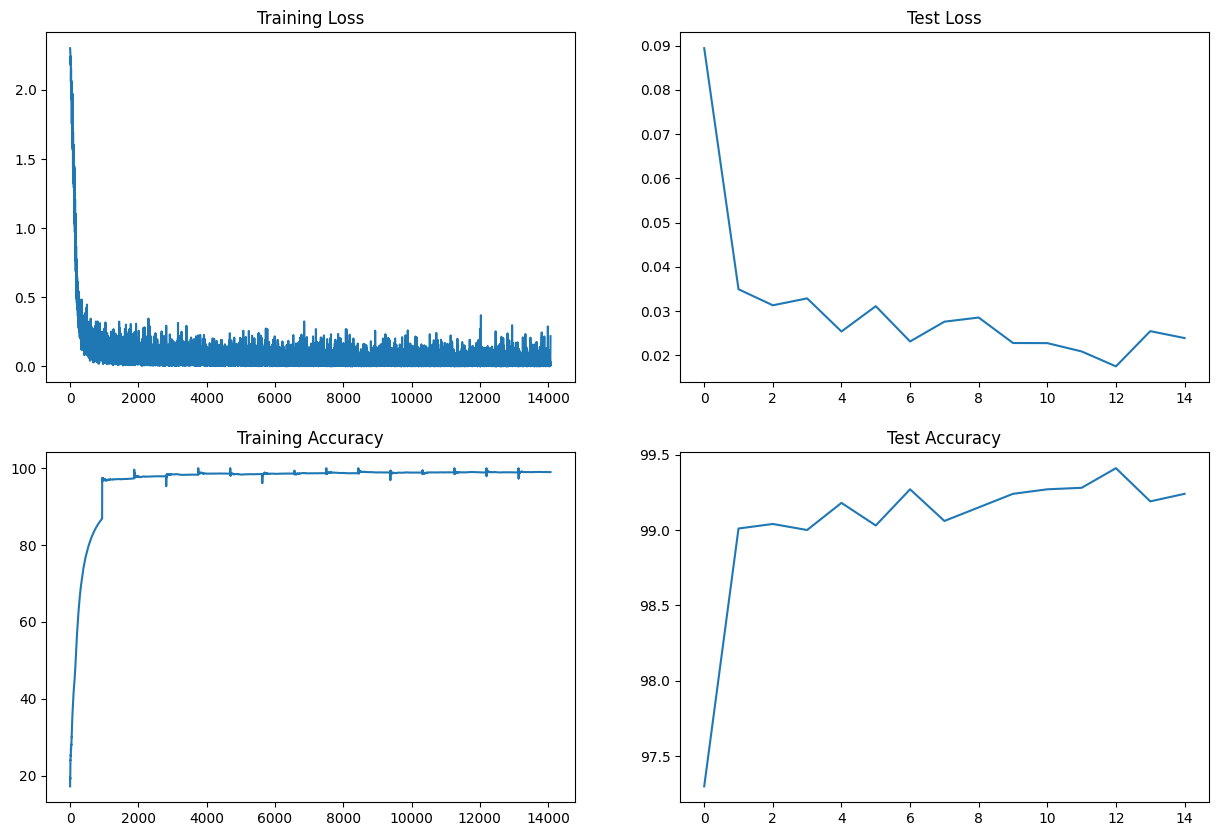

In [26]:
t = [t_items.item() for t_items in train_losses]


import matplotlib.pyplot as plt


fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

**Target:**
  
*   Reduce parameters bellow 10k count
*   Use skip connections
*   Limit the 15 epoch
*   Achieve test accuracy > 99.40%


**Results:**


*   Parameters: 7,902
*   Best Training Accuracy: 98.99
*   Best Test Accuracy: 99.41


**Analysis:**


*   Very light weight Model
*   Added Batch Normalization, MaxPool2d and dropout = 0.1
*   Initial 5 epocs has more test accuracy than training accuracy